In [1]:
import pandas as pd

In [2]:
download_url = "train.csv"

In [3]:
df = pd.read_csv(download_url)
df.job_functions = df.job_functions.apply(eval)
df.industries = df.industries.apply(eval)

df.head()

,job_title,seniority_level,employment_type,industries,job_functions
0,Manual Tester,Entry level,Full-time,[Information Technology and Services],"[Engineering, Information Technology]"
1,Field Marketing Representative,Entry level,Full-time,"[Food & Beverages, Wholesale, Retail]","[Marketing, Sales]"
2,Consumer Relations Representative,Associate,Full-time,"[Marketing and Advertising, Food & Beverages, ...",[Other]
3,Software Engineer In Test,Mid-Senior level,Full-time,"[Information Technology and Services, Computer...","[Information Technology, Quality Assurance]"
4,Electrician,Entry level,Full-time,"[Electrical/Electronic Manufacturing, Construc...","[Management, Manufacturing]"


In [4]:
download_url = "test.csv"
test = pd.read_csv(download_url)
test.job_functions = test.job_functions.apply(eval)
test.industries = test.industries.apply(eval)

test.head()

,job_title,seniority_level,employment_type,industries,job_functions
0,"CAD Drafter - Dallas, TX",Not Applicable,Full-time,"[Construction, Civil Engineering, Real Estate]","[Design, Art/Creative, Information Technology]"
1,COMPUTER ANALYST NOC-2171,Entry level,Full-time,"[Information Technology and Services, Computer...",[Information Technology]
2,Videographer,Entry level,Full-time,"[Marketing and Advertising, Internet, Financia...","[Design, Art/Creative, Information Technology]"
3,Sales Representative,Entry level,Full-time,"[Building Materials, Machinery, Mechanical or ...","[Sales, Business Development]"
4,Open job positions for all employees,Entry level,Full-time,"[Electrical/Electronic Manufacturing, Construc...",[Other]


In [5]:
from nltk.corpus import stopwords
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/hrvoje/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
import re
#REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
#BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    #text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    #text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    #text = text.replace('x', '')
    #text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text


df.job_title = df.job_title.apply(clean_text)
df.job_title = df.job_title.str.replace('\d+', '')

/tmp/ipykernel_4256/904907553.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  df.job_title = df.job_title.str.replace('\d+', '')


In [7]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="multitask-classification", entity="bresha")

wandb: Currently logged in as: bresha (use `wandb login --relogin` to force relogin)


In [8]:
config = wandb.config
config.learning_rate = 0.01
config.lower_case = True
config.optimizer = "adam"
config.batch_size = 2048
config.dropout = 0.2
config.lstm = 512
config.epochs = 10
config.MAX_NB_WORDS = 10000
config.MAX_SEQUENCE_LENGTH = 16
config.EMBEDDING_DIM = 512

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(
    num_words=config.MAX_NB_WORDS, 
    filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', 
    lower=config.lower_case)

tokenizer.fit_on_texts(df.job_title.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 17893 unique tokens.


In [11]:
X = tokenizer.texts_to_sequences(df.job_title.values)

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
X = pad_sequences(X, maxlen=config.MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (100000, 16)


In [14]:
Y_sen = pd.get_dummies(df.seniority_level).values
print('Shape of label tensor:', Y_sen.shape)


Shape of label tensor: (100000, 7)


In [15]:
Y_emp = pd.get_dummies(df.employment_type).values
print('Shape of label tensor:', Y_emp.shape)


Shape of label tensor: (100000, 7)


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_sen_train, y_sen_test, y_emp_train, y_emp_test = train_test_split(X, Y_sen, Y_emp, test_size=0.2, random_state=42)

In [18]:
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model

In [19]:
input_layer = Input(name="job_title", shape=config.MAX_SEQUENCE_LENGTH)

emb = Embedding(config.MAX_NB_WORDS, config.EMBEDDING_DIM, input_length=config.MAX_SEQUENCE_LENGTH)(input_layer)
lstm = LSTM(config.lstm, dropout=config.dropout)(emb)
out = Dense(7, activation='softmax', name='sen')(lstm)
out2 = Dense(7, activation='softmax', name='emp')(lstm)

model = Model(inputs=input_layer, outputs=[out, out2])

2022-02-22 19:02:49.120000: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 19:02:49.175512: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 19:02:49.175705: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 19:02:49.176075: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 job_title (InputLayer)         [(None, 16)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 16, 512)      5120000     ['job_title[0][0]']              
                                                                                                  
 lstm (LSTM)                    (None, 512)          2099200     ['embedding[0][0]']              
                                                                                                  
 sen (Dense)                    (None, 7)            3591        ['lstm[0][0]']                   
                                                                                              

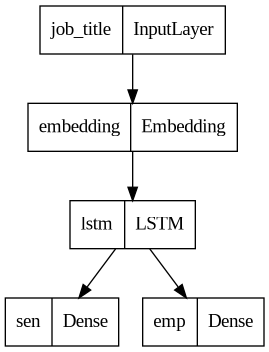

In [21]:
import tensorflow
tensorflow.keras.utils.plot_model(model)

In [22]:
model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])

In [23]:
history = model.fit(X_train, [ y_sen_train, y_emp_train ], \
                    batch_size=config.batch_size, verbose=1, \
                    validation_data=(X_test, [y_sen_test, y_emp_test]), \
                    epochs=config.epochs, \
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True),
                               WandbCallback(save_model=False)])

Epoch 1/10


2022-02-22 19:02:52.118681: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8301


40/40 [==============================] - 6s 97ms/step - loss: 2.1149 - sen_loss: 1.4317 - emp_loss: 0.6832 - sen_accuracy: 0.4722 - emp_accuracy: 0.8507 - val_loss: 1.7583 - val_sen_loss: 1.2094 - val_emp_loss: 0.5489 - val_sen_accuracy: 0.5565 - val_emp_accuracy: 0.8697
Epoch 2/10
40/40 [==============================] - 3s 86ms/step - loss: 1.6218 - sen_loss: 1.0946 - emp_loss: 0.5273 - sen_accuracy: 0.6155 - emp_accuracy: 0.8712 - val_loss: 1.5001 - val_sen_loss: 0.9853 - val_emp_loss: 0.5148 - val_sen_accuracy: 0.6607 - val_emp_accuracy: 0.8744
Epoch 3/10
40/40 [==============================] - 3s 86ms/step - loss: 1.4073 - sen_loss: 0.9250 - emp_loss: 0.4823 - sen_accuracy: 0.6768 - emp_accuracy: 0.8776 - val_loss: 1.4184 - val_sen_loss: 0.9376 - val_emp_loss: 0.4808 - val_sen_accuracy: 0.6805 - val_emp_accuracy: 0.8757
Epoch 4/10
40/40 [==============================] - 3s 86ms/step - loss: 1.2996 - sen_loss: 0.8517 - emp_loss: 0.4479 - sen_accuracy: 0.7047 - emp_accuracy: 0.882

In [24]:
new_title = "Junior Research Scientist"
new_title = [clean_text(new_title)]
seq = tokenizer.texts_to_sequences(new_title)
padded = pad_sequences(seq, maxlen=config.MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
pred

[array([[0.61334467, 0.00332635, 0.12112863, 0.00230656, 0.00063413,
         0.09990674, 0.15935293]], dtype=float32),
 array([[3.7938692e-02, 9.3248487e-01, 1.4072924e-03, 1.5941833e-03,
         1.8252142e-02, 8.1350068e-03, 1.8780280e-04]], dtype=float32)]

In [28]:
for row in pred:
    print(row.argmax())

0
1
